In [1]:
import json
from qutip import *
import numpy as np
import scipy
import cmath
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import itertools
from numpy.random import seed
from numpy.random import rand
from itertools import product
from scipy.misc import derivative
from scipy import optimize
from functools import wraps
from time import time
from scipy.optimize import minimize
from matplotlib import gridspec


In [2]:
#Wrapper to time functions
def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        ti = time()
        result = f(*args, **kw)
        tf = time()
        t = tf-ti
        return result, t
    return wrap

In [3]:
#Make basis and get sz values
def operatorCreation(N):
    #operator definitionis
    si = qeye(2)
    sx = 0.5*sigmax()
    sy = 0.5*sigmay()
    sz = 0.5*sigmaz()

    sx_list = []
    sy_list = []
    sz_list = []
    

    for n in range(N):
        op_list = []
        for m in range(N):
            op_list.append(si)

        op_list[n] = sx
        sx_list.append(tensor(op_list))

        op_list[n] = sy
        sy_list.append(tensor(op_list))

        op_list[n] = sz
        sz_list.append(tensor(op_list))
        
        op_list[n] = si
    id = tensor(op_list)
        
    return sx_list, sy_list, sz_list,id

In [4]:
#Construct Hamiltonian
def hamiltonian(N,B,A0):
    sx_list = operatorCreation(N)[0]
    sy_list = operatorCreation(N)[1]
    sz_list = operatorCreation(N)[2]
    H = B*sz_list[0] 
    for n in range(N-1):
        H += A0*sz_list[0]*sz_list[n+1] + A0*sx_list[0]*sx_list[n+1] + A0*sy_list[0]*sy_list[n+1]
    return H

In [5]:
#Check if dengerate
def CheckDegenerate(H):
    estates = H.eigenstates()
    lowState = estates[0][0]
    secLowState = estates[0][1]
    if (abs(lowState-secLowState))<= 1e-10:
        return True
    else:
        return False

In [6]:
#Get Ground State Energy and Wavefuntion
class GroundState:
    
    def __init__(self, N, B, A0):
        self.hamiltonian = hamiltonian(N, B, A0)
     
    @timing
    def __call__(self):
        #find ground state
        H = self.hamiltonian
        groundState= H.groundstate()
        return groundState[0],groundState[1]

In [7]:
#Make basis and get sz values
def basisCreation(N):
    sz_list = operatorCreation(N)[2]
    Sbasis = []
    basisState = []
   
    for j in range(2):
        basisState.append(basis(2,j))
    b = itertools.product(basisState,repeat=N)
    basisTensor = list(b)
    #makes Sbasis the correct dimesion of Qobj
    for i in range(2**N):
        c = basisTensor[i][0]
        for j in range(N-1):
            c = tensor(c,basisTensor[i][j+1])
        Sbasis.append(c)

    
    #get sz values for basis states
    sz = np.zeros((2**N,N), dtype = complex)
    a = [[1 for j in range(N)] for i in range(2**N)]
    for i in range(2**N):
        for j in range(N):
            #matrix element <bra|Sz|ket>
            sz[i][j] = sz_list[j].matrix_element(Sbasis[i],Sbasis[i])
    return Sbasis, sz


In [8]:
#get randomized RBM parameters (between zero and 1)
def ranRBMpar(N,M):
    par = 1-2*np.random.rand(2*(N+M+N*M))
    return par

In [9]:
#Function to give RBM wavefuntion
def RBM_ansatz(par,N, M):
    Sbasis = basisCreation(N)[0]
    sz = basisCreation(N)[1]
    #make parmeters complex
    num = N+M+N*M
    parC = np.vectorize(complex)(par[:num],par[num:])
    a = parC[:N]
    b = parC[N:N+M]
    W = parC[N+M:].reshape(M,N)
    expTerm = np.zeros(2**N, dtype = complex)
    coshTerm = np.zeros((M,2**N), dtype = complex)
    hidProduct = np.zeros(2**N, dtype = complex)
    psiMValues = np.zeros(2**N, dtype = complex)
    psiM = 0*Sbasis[0]

    for i in range(2**N):
        for m in range(M):
            coshTerm[m][i] = 2*np.cosh(np.dot(W[m],sz[i]) + b[m])
    hidProduct = np.prod(coshTerm, axis = 0) 
    
    for i in range(2**N):
        expTerm[i] = np.exp(np.dot(a,sz[i]))
        psiMValues[i] = expTerm[i]*hidProduct[i]
        psiM += psiMValues[i]*Sbasis[i]
    psiNorm = psiM.unit()
    return psiNorm


In [10]:
#Variation Energy Definition
def varEnergy(par,N, M, H):
    psiM = RBM_ansatz(par,N, M)
    E = expect(H,psiM)
    norm = psiM.norm()**2
    Enorm = E/norm
    return Enorm

In [11]:
#Energy Partials
def gradEnergy(par,N, M,H):
    eps = 0.001
    return optimize.approx_fprime(par,varEnergy,eps, N, M,H)

In [12]:
#Conjugate Gradient Descent
class ConGradDescent:
    
    def __init__(self, N, B, A0):
        H = hamiltonian(N, B, A0)
        isDeg = CheckDegenerate(H)
        if (isDeg == True):
            raise ValueError("Hamiltonian has degenerate ground state")
        else:
            self.hamiltonian = H
     
    @timing 
    def __call__(self, N, M,par):
        H = self.hamiltonian
        min = scipy.optimize.fmin_cg(varEnergy,par,args= (N,M,H),gtol = 1e-04, full_output=True, retall = True, disp=True)
        #Ground State
        found_gs = RBM_ansatz(min[0],N, M)
        found_gs = found_gs.unit()
        #Ground State Energy
        found_gsEnergy =varEnergy(min[0], N, M,H)
        return min, found_gs, found_gsEnergy  

In [13]:
#Error Calculation
def err(found_gs,gs,found_gsEnergy,gsEnergy):
    engErr = np.abs(found_gsEnergy-gsEnergy)
    waveFunctionErr = found_gs.dag()*gs
    waveFunctionErr = 1-waveFunctionErr.norm()
    
    return engErr,waveFunctionErr


In [14]:
#Ensures conjugate gradient descent convergance
def CgdConvergance(N, M, B, A0):
    #random parameters
    par = ranRBMpar(N,M)
    #performs conjugate gradient descent
    conGradDescent = ConGradDescent(N, B, A0)
    cgd = conGradDescent(N, M,par)
    #get actual ground state
    groundState = GroundState(N,B,A0)
    ed = groundState()
    #Calculate Error
    error = err(cgd[0][1],ed[0][1],cgd[0][2],ed[0][0])
    relativeErr = np.abs(error[0]/ed[0][0])
    print('relativeErr',relativeErr)
    #Run again if the relative error is larger than 0.01
    runs = 1
    while(relativeErr>0.01):
        par = ranRBMpar(N,M)
        cgd = conGradDescent(N, M,par)
        error = err(cgd[0][1],ed[0][1],cgd[0][2],ed[0][0])
        relativeErr = np.abs(error[0]/ed[0][0])
        runs += 1
        print('relativeErr in Loop',relativeErr)
    return cgd, error, runs

## Run Statistics

In [15]:
# Runs inforamtion is saved at the following locations:
# N=2 M=1 Data/May14/N2M1.json
# N=2 M=2 Data/May14/N2M2.json
# N=2 M=3 Data/May14/N2M3.json
# N=2 M=4 Data/May14/N2M4.json

In [16]:
#How to read saved data
saved = []
with open('Data/May12/N2M3Bpi.json') as file:
    for line in file:
        saved.append(json.loads(line))

cgdTime,cgdEngErr,cgdStateErr,edTime,len(hisIt)=saved

SyntaxError: can't assign to function call (<ipython-input-16-2026ea0f3080>, line 7)

## Generating Data

In [20]:
#Parameter definition 
N= 2
M=6
B = 1
A0 = 1

cgdResults = [] #gives ground state estimation at each iteration of gd
cgdState = []
cgdTime = []
cgdEngErr = []
cgdStateErr = []

edState = []
edTime = []
ActualEng = []

hisIt = np.arange(100)

In [21]:
for i in range(len(hisIt)):
    par = ranRBMpar(N,M)
    
    #gradient descent
    conGradDescent = ConGradDescent(N, B, A0)
    cgd = conGradDescent(N,M,par)
    cgdResults.append(cgd)
    cgdState.append(cgd[0])
    cgdTime.append(cgd[1])
    
    
    #exact diagonalization 
    groundState = GroundState(N,B,A0)
    ed = groundState()
    edState.append(ed[0])
    edTime.append(ed[1])
    
    
    #Error
    cgdEngTemp = cgd[0][2]
    edEngTemp = ed[0][0]
    
    ActualEng.append(edEngTemp)
    cgdStateTemp = cgd[0][1]
    edStateTemp = ed[0][1]

    
    cgdErrTemp = err(cgdStateTemp,edStateTemp,cgdEngTemp,edEngTemp)  
    cgdEngErr.append(cgdErrTemp[0])
    cgdStateErr.append(cgdErrTemp[1])
   


Optimization terminated successfully.
         Current function value: -0.957107
         Iterations: 17
         Function evaluations: 1932
         Gradient evaluations: 46
Optimization terminated successfully.
         Current function value: -0.957105
         Iterations: 13
         Function evaluations: 1260
         Gradient evaluations: 30
Optimization terminated successfully.
         Current function value: -0.749994
         Iterations: 6
         Function evaluations: 798
         Gradient evaluations: 19
Optimization terminated successfully.
         Current function value: -0.957107
         Iterations: 20
         Function evaluations: 1764
         Gradient evaluations: 42
Optimization terminated successfully.
         Current function value: -0.957107
         Iterations: 36
         Function evaluations: 3024
         Gradient evaluations: 72
Optimization terminated successfully.
         Current function value: -0.957105
         Iterations: 35
         Function eval

Optimization terminated successfully.
         Current function value: -0.750000
         Iterations: 3
         Function evaluations: 714
         Gradient evaluations: 17
Optimization terminated successfully.
         Current function value: -0.957105
         Iterations: 93
         Function evaluations: 7014
         Gradient evaluations: 167
Optimization terminated successfully.
         Current function value: -0.957103
         Iterations: 25
         Function evaluations: 3150
         Gradient evaluations: 75
Optimization terminated successfully.
         Current function value: -0.957096
         Iterations: 25
         Function evaluations: 2562
         Gradient evaluations: 61
Optimization terminated successfully.
         Current function value: -0.957105
         Iterations: 61
         Function evaluations: 4956
         Gradient evaluations: 118
Optimization terminated successfully.
         Current function value: -0.957107
         Iterations: 16
         Function ev

Optimization terminated successfully.
         Current function value: -0.957107
         Iterations: 34
         Function evaluations: 2688
         Gradient evaluations: 64
Optimization terminated successfully.
         Current function value: -0.957107
         Iterations: 33
         Function evaluations: 2436
         Gradient evaluations: 58
Optimization terminated successfully.
         Current function value: -0.957107
         Iterations: 32
         Function evaluations: 3318
         Gradient evaluations: 79
Optimization terminated successfully.
         Current function value: -0.957106
         Iterations: 22
         Function evaluations: 2226
         Gradient evaluations: 53
Optimization terminated successfully.
         Current function value: -0.957103
         Iterations: 26
         Function evaluations: 2688
         Gradient evaluations: 64
Optimization terminated successfully.
         Current function value: -0.957107
         Iterations: 15
         Function ev

In [22]:
#Save data to JSON file
data = [cgdTime,cgdEngErr,cgdStateErr,edTime,len(hisIt)]
open("Data/May14/N2M6.json", "w").close()
with open('Data/May14/N2M6.json', 'a') as file:
    for item in data: 
        line = json.dumps(item)
        file.write(line + '\n')

In [67]:
#How to read saved data
test = []
with open('Data/May14/N2M1.json') as file:
    for line in file:
        test.append(json.loads(line))
cgdTimeN2M1,cgdEngErrN2M1,cgdStateErrN2M1,edTimeN2M1,lenN2M1 = test

Text(0, 0.5, 'Runtime')

<Figure size 432x288 with 0 Axes>

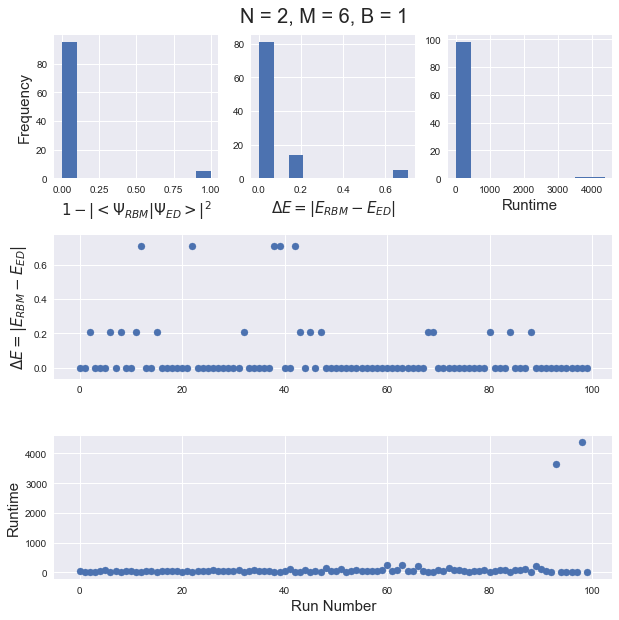

In [23]:
plt.figure(constrained_layout=True)
plt.figure(figsize=(10,10))
ttl = plt.suptitle("N = 2, M = 6, B = 1",size =20)
gs = gridspec.GridSpec(ncols=3, nrows=3, hspace = 0.4)
ttl.set_position([.5, 0.92])



ax1 = plt.subplot(gs[0, 0])
ax1 .hist(cgdStateErr, bins=10) 
ax1 .set_xlabel("$1-|<\Psi_{RBM}|\Psi_{ED}>|^2$",size = 15)
ax1.set_ylabel("Frequency",size = 15)



ax2 = plt.subplot(gs[0, 1])
ax2.hist(cgdEngErr, bins=10) 
ax2.set_xlabel("$\Delta E = |E_{RBM}-E_{ED}|$",size = 15)



ax3 = plt.subplot(gs[0, 2])
ax3.hist(cgdTime, bins=10) 
ax3.set_xlabel("Runtime",size = 15)


ax4 = plt.subplot(gs[1, :])
ax4.scatter(hisIt,cgdEngErr) 
ax4 .set_ylabel("$\Delta E = |E_{RBM}-E_{ED}|$", size = 15)


ax5 = plt.subplot(gs[2, :])
ax5.scatter(hisIt,cgdTime)  
ax5.set_xlabel("Run Number",size = 15)
ax5 .set_ylabel("Runtime", size = 15)












In [24]:
avEngErr = np.sum(cgdEngErr)/(len(hisIt))
avStateErr = np.sum(cgdStateErr)/(len(hisIt))
avRunTime = np.sum(cgdTime)/(len(hisIt))
print('Average Energy Error: ', avEngErr )
print('Average Ground State Error: ', avStateErr )
print('Average Run Time: ', avRunTime )

cutOff = 0.0001
runsCutOff = sum(i>cutOff for i in cgdEngErr)
prob = (runsCutOff/100)
print("Number of runs abover 0.0005 error:", runsCutOff )
print("Prob of sucess:",  f"{1-prob:.4f}" )
print("Prob of sucess two runs:", f"{1-prob**2:.4f}" )
print("Prob of sucess three runs:", f"{1-prob**3:.4f}" )




Average Energy Error:  0.06435454605596456
Average Ground State Error:  0.06048603309738071
Average Run Time:  133.86758399963378
Number of runs abover 0.0005 error: 19
Prob of sucess: 0.8100
Prob of sucess two runs: 0.9639
Prob of sucess three runs: 0.9931


## Load all saved data

In [114]:
#How to read saved data
saved = []
with open('Data/May14/N2M1.json') as file:
    for line in file:
        saved.append(json.loads(line))

cgdTimeN2M1,cgdEngErrN2M1,cgdStateErrN2M1,edTimeN2M1,lenN2M1=saved

In [115]:
#How to read saved data
saved = []
with open('Data/May14/N2M2.json') as file:
    for line in file:
        saved.append(json.loads(line))

cgdTimeN2M2,cgdEngErrN2M2,cgdStateErrN2M2,edTimeN2M2,lenN2M2=saved

In [116]:
#How to read saved data
saved = []
with open('Data/May14/N2M3.json') as file:
    for line in file:
        saved.append(json.loads(line))

cgdTimeN2M3,cgdEngErrN2M3,cgdStateErrN2M3,edTimeN2M3,lenN2M3=saved

In [117]:
#How to read saved data
saved = []
with open('Data/May14/N2M4.json') as file:
    for line in file:
        saved.append(json.loads(line))

cgdTimeN2M4,cgdEngErrN2M4,cgdStateErrN2M4,edTimeN2M4,lenN2M4=saved

In [118]:
#How to read saved data
saved = []
with open('Data/May14/N2M5.json') as file:
    for line in file:
        saved.append(json.loads(line))

cgdTimeN2M5,cgdEngErrN2M5,cgdStateErrN2M5,edTimeN2M5,lenN2M5=saved

In [119]:
#How to read saved data
saved = []
with open('Data/May14/N3M1.json') as file:
    for line in file:
        saved.append(json.loads(line))

cgdTimeN3M1,cgdEngErrN3M1,cgdStateErrN3M1,edTimeN3M1,lenN3M1=saved

In [120]:
#How to read saved data
saved = []
with open('Data/May14/N3M2.json') as file:
    for line in file:
        saved.append(json.loads(line))

cgdTimeN3M2,cgdEngErrN3M2,cgdStateErrN3M2,edTimeN3M2,lenN3M2=saved

In [121]:
#How to read saved data
saved = []
with open('Data/May14/N3M3.json') as file:
    for line in file:
        saved.append(json.loads(line))

cgdTimeN3M3,cgdEngErrN3M3,cgdStateErrN3M3,edTimeN3M3,lenN3M3=saved

In [186]:
#How to read saved data
saved = []
with open('Data/May14/N3M4.json') as file:
    for line in file:
        saved.append(json.loads(line))

cgdTimeN3M4,cgdEngErrN3M4,cgdStateErrN3M4,edTimeN3M4,lenN3M4=saved

In [187]:
#How to read saved data
saved = []
with open('Data/May14/N3M5.json') as file:
    for line in file:
        saved.append(json.loads(line))

cgdTimeN3M5,cgdEngErrN3M5,cgdStateErrN3M5,edTimeN3M5,lenN3M5=saved

In [124]:
#How to read saved data
saved = []
with open('Data/May14/N4M1.json') as file:
    for line in file:
        saved.append(json.loads(line))

cgdTimeN4M1,cgdEngErrN4M1,cgdStateErrN4M1,edTimeN4M1,lenN4M1=saved

In [125]:
#How to read saved data
saved = []
with open('Data/May14/N4M2.json') as file:
    for line in file:
        saved.append(json.loads(line))

cgdTimeN4M2,cgdEngErrN4M2,cgdStateErrN4M2,edTimeN4M2,lenN4M2=saved

In [126]:
#How to read saved data
saved = []
with open('Data/May14/N4M3.json') as file:
    for line in file:
        saved.append(json.loads(line))

cgdTimeN4M3,cgdEngErrN4M3,cgdStateErrN4M3,edTimeN4M3,lenN4M3=saved

In [127]:
#How to read saved data
saved = []
with open('Data/May14/N4M4.json') as file:
    for line in file:
        saved.append(json.loads(line))

cgdTimeN4M4,cgdEngErrN4M4,cgdStateErrN4M4,edTimeN4M4,lenN4M4=saved

In [128]:
#How to read saved data
saved = []
with open('Data/May14/N4M5.json') as file:
    for line in file:
        saved.append(json.loads(line))

cgdTimeN4M5,cgdEngErrN4M5,cgdStateErrN4M5,edTimeN4M5,lenN4M5=saved

In [201]:
engErr = [cgdEngErrN2M1,cgdEngErrN2M2,cgdEngErrN2M3,cgdEngErrN2M4,cgdEngErrN2M5,cgdEngErrN3M1,cgdEngErrN3M2,cgdEngErrN3M3,cgdEngErrN3M4,cgdEngErrN3M4,cgdEngErrN3M5,cgdEngErrN4M1,cgdEngErrN4M2, cgdEngErrN4M3,cgdEngErrN4M4,cgdEngErrN4M5]
stateErr = [cgdStateErrN2M1,cgdStateErrN2M2,cgdStateErrN2M3,cgdStateErrN2M4,cgdStateErrN2M5,cgdStateErrN3M1,cgdStateErrN3M2,cgdStateErrN3M3,cgdStateErrN3M4,cgdStateErrN3M4,cgdStateErrN3M5,cgdStateErrN4M1,cgdStateErrN4M2, cgdStateErrN4M3,cgdStateErrN4M4,cgdStateErrN4M5]
time= [cgdTimeN2M1,cgdTimeN2M2,cgdTimeN2M3,cgdTimeN2M4,cgdTimeN2M5,cgdTimeN3M1,cgdTimeN3M2,cgdTimeN3M3,cgdTimeN3M4,cgdTimeN3M5,cgdTimeN4M1,cgdTimeN4M2,cgdTimeN4M3,cgdTimeN4M4,cgdTimeN4M5]
lengths = [lenN2M1,lenN2M2,lenN2M3,lenN2M4,lenN2M5,lenN3M1,lenN3M2,lenN3M3,lenN3M4,lenN3M5,lenN4M1,lenN4M2,lenN4M3,lenN4M4,lenN4M5]

avEngErr = []
avStateErr = []
avRunTime = []
for i in range(len(EngErr)):
    avEngErrTemp = np.sum(engErr[i])/(lengths[i])
    avEngErr.append(avEngErrTemp)
    avStateErrTemp = np.sum(stateErr[i])/(lengths[i])
    avStateErr.append(avStateErrTemp)
    avRunTimeTemp = np.sum(time[i])/(lengths[i])
    avRunTime.append(avRunTimeTemp)



print(avEngErr[8])
print(avEngErr[9])
print()

0.09055519664133936
0.09055519664133936


<Figure size 432x288 with 0 Axes>

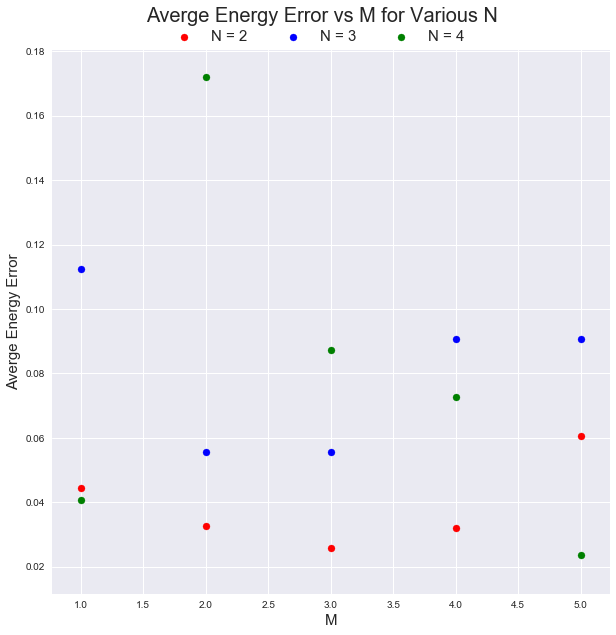

In [194]:
x = np.arange(1,6)
plt.figure(constrained_layout=True)
plt.figure(figsize=(10,10))
ttl = plt.suptitle("Averge Energy Error vs M for Various N",size =20)
gs = gridspec.GridSpec(ncols=1, nrows=1, hspace = 0.4)
ttl.set_position([.5, 0.94])


ax4 = plt.subplot(gs[0, :])
#ax4.set_yscale('log')
ax4.scatter(x,avEngErr[0:5], color='r',label='N = 2') 
ax4.scatter(x,avEngErr[5:10],color='b',label='N = 3') 
ax4.scatter(x,avEngErr[10:15], color='g',label='N = 4') 
ax4 .set_ylabel("Averge Energy Error", size = 15)
ax4.set_xlabel("M",size = 15)
plt.legend(loc = (0.2, 1),fontsize = 15,ncol=3)

<Figure size 432x288 with 0 Axes>

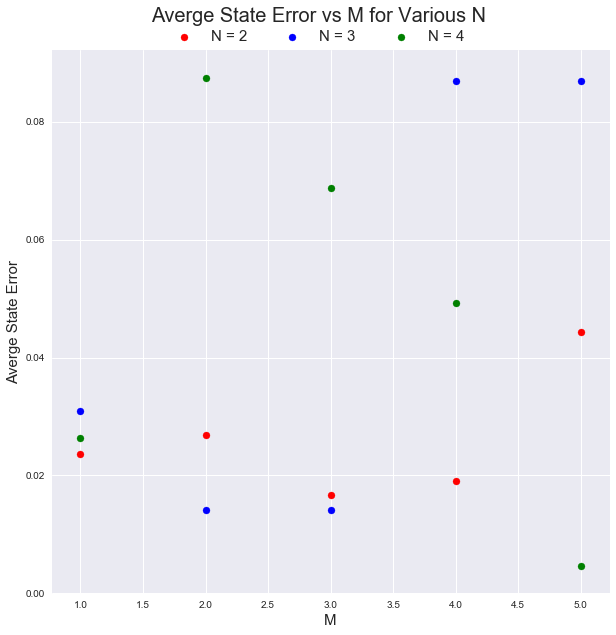

In [195]:
x = np.arange(1,6)
plt.figure(constrained_layout=True)
plt.figure(figsize=(10,10))
ttl = plt.suptitle("Averge State Error vs M for Various N ",size =20)
gs = gridspec.GridSpec(ncols=1, nrows=1, hspace = 0.4)
ttl.set_position([.5, 0.94])


ax4 = plt.subplot(gs[0, :])
#ax4.set_yscale('log')
ax4.scatter(x,avStateErr[0:5], color='r',label='N = 2') 
ax4.scatter(x,avStateErr[5:10],color='b',label='N = 3') 
ax4.scatter(x,avStateErr[10:15], color='g',label='N = 4') 
ax4 .set_ylabel("Averge State Error", size = 15)
ax4.set_xlabel("M",size = 15)
plt.legend(loc = (0.2, 1),fontsize = 15,ncol=3)

<Figure size 432x288 with 0 Axes>

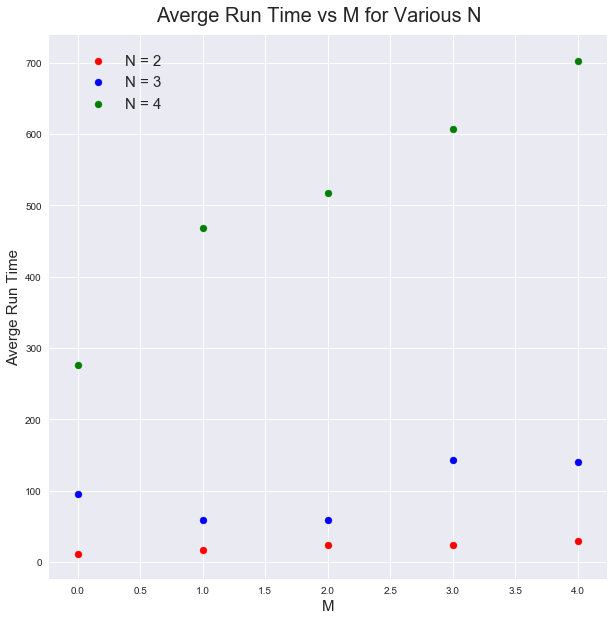

In [196]:
x = np.arange(5)
plt.figure(constrained_layout=True)
plt.figure(figsize=(10,10))
ttl = plt.suptitle("Averge Run Time vs M for Various N",size =20)
gs = gridspec.GridSpec(ncols=1, nrows=1, hspace = 0.4)
ttl.set_position([.5, 0.92])


ax4 = plt.subplot(gs[0, :])
#ax4.set_yscale('log')
ax4.scatter(x,avRunTime[0:5], color='r',label='N = 2') 
ax4.scatter(x,avRunTime[5:10],color='b',label='N = 3') 
ax4.scatter(x,avRunTime[10:15], color='g',label='N = 4') 
ax4 .set_ylabel("Averge Run Time", size = 15)
ax4.set_xlabel("M",size = 15)
plt.legend(loc = (0.05, 0.85),fontsize = 15,ncol=1)

<Figure size 432x288 with 0 Axes>

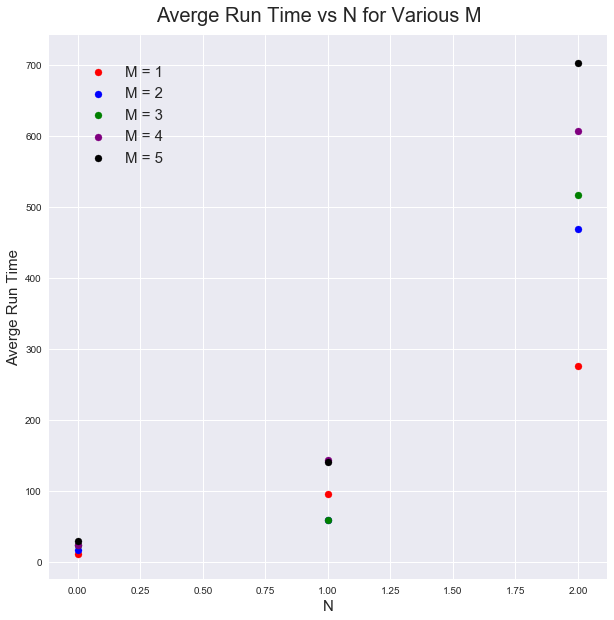

In [192]:
x = np.arange(3)
plt.figure(constrained_layout=True)
plt.figure(figsize=(10,10))
ttl = plt.suptitle("Averge Run Time vs N for Various M",size =20)
gs = gridspec.GridSpec(ncols=1, nrows=1, hspace = 0.4)
ttl.set_position([.5, 0.92])


ax4 = plt.subplot(gs[0, :])
#ax4.set_yscale('log')
ax4.scatter(x,[avRunTime[0],avRunTime[5],avRunTime[10]], color='r',label='M = 1') 
ax4.scatter(x,[avRunTime[1],avRunTime[6],avRunTime[11]], color='b',label='M = 2')
ax4.scatter(x,[avRunTime[2],avRunTime[7],avRunTime[12]], color='g',label='M = 3')
ax4.scatter(x,[avRunTime[3],avRunTime[8],avRunTime[13]], color='purple',label='M = 4')
ax4.scatter(x,[avRunTime[4],avRunTime[9],avRunTime[14]], color='black',label='M = 5')
ax4 .set_ylabel("Averge Run Time", size = 15)
ax4.set_xlabel("N",size = 15)
plt.legend(loc = (0.05, 0.75),fontsize = 15,ncol=1)